In [30]:
# 导入open方法
from io import open
# 用于字符规范化
import unicodedata
# 导入正则表达式的包
import re
# 导入随机处理数据的包
import random
# 导入torch相关的包
import torch
import torch.nn as nn
import torch.nn.functional as F
# 导入优化方法的工具包
from torch import optim

import time
import math
import matplotlib.pyplot as plt
# 设备的选择, 可以选择在GPU上运行或者在CPU上运行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# 定义起始标志
SOS_token = 0
# 定义结束标志
EOS_token = 1
data_path = 'data/eng-fra.txt'

In [32]:
class Lang():
    def __init__(self, name):
        # name: 参数代表传入某种语言的名字
        self.name = name
        # 初始化单词到索引的映射字典
        self.word2index = {}
        # 初始化索引到单词的映射字典, 其中0, 1对应的SOS, EOS已经在字典中了
        self.index2word = {0: "SOS", 1: "EOS"}
        # 初始化词汇对应的数字索引, 从2开始, 因为0, 1已经被开始字符和结束字符占用了
        self.n_words = 2
    
    def addSentence(self, sentence):
        # 添加句子的函数, 将整个句子中所有的单词依次添加到字典中
        # 因为英文, 法文都是空格进行分割的语言, 直接进行分词就可以
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        # 添加单词到类内字典中, 将单词转换为数字
        # 首先判断word是否已经在self.word2index字典的key中
        if word not in self.word2index:
            # 添加的时候, 索引值取当前类中单词的总数量
            self.word2index[word] = self.n_words
            # 再添加翻转的字典
            self.index2word[self.n_words] = word
            # 第三步更新类内的单词总数量
            self.n_words += 1

In [33]:
def timeSince(since):
    # since: 代表模型训练的开始时间
    # 首先获取当前时间
    now = time.time()
    # 计算得到时间差
    s = now - since
    # 将s转换为分钟, 秒的形式
    m = math.floor(s / 60)
    # 计算余数的秒
    s -= m * 60
    # 按照指定的格式返回时间差
    return '%dm %ds' % (m, s)

In [34]:
# 将unicode字符串转换为ASCII字符串, 主要用于将法文的重音符号去除掉
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                    if unicodedata.category(c) != 'Mn')


# 定义字符串规范化函数
def normalizeString(s):
    # 第一步使字符转变为小写并去除掉两侧的空白符, 再调用上面的函数转换为ASCII字符串
    s = unicodeToAscii(s.lower().strip())
    # 在.!?前面加一个空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 使用正则表达式将字符串中不是大小写字符和正常标点符号的全部替换成空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [35]:
def readLangs(lang1, lang2):
    # lang1: 代表源语言的名字
    # lang2: 代表目标语言的名字
    # 整个函数返回对应的两个类对象, 以及语言对的列表
    lines = open(data_path, encoding='utf-8').read().strip().split('\n')
    # 对lines列表中的句子进行标准化处理, 并以\t进行再次划分, 形成子列表
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # 直接初始化两个类对象
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

In [36]:
# 设置组成句子中单词或标点的最多个数
MAX_LENGTH = 20

# 选择带有指定前缀的英文源语言的语句数据作为训练数据
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


# 过滤语言对的具体逻辑函数
def filterPair(pair):
    # 当前传入的pair是一个语言对的形式
    # pair[0]代表英文源语句, 长度应小于MAX_LENGTH， 并且以指定前缀开始
    # pair[1]代表法文源语句, 长度应小于MAX_LENGTH
    return len(pair[0].split(' ')) < MAX_LENGTH and pair[0].startswith(eng_prefixes) and len(pair[1].split(' ')) < MAX_LENGTH
    #return len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH

# 过滤语言对的函数
def filterPairs(pairs):
    # 函数直接遍历列表中的每个语言字符串并调用filterPair()函数即可
    return [pair for pair in pairs if filterPair(pair)]

In [37]:
# 整合数据预处理的函数
def prepareData(lang1, lang2):
    # lang1: 代表源语言的名字, 英文
    # lang2: 代表目标语言的名字, 法文
    # 第一步通过调用readLangs()函数得到两个类对象, 并得到字符串类型的语言对的列表
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    # 第二步对字符串类型的列表进行过滤操作
    pairs = filterPairs(pairs)
    # 对过滤后的语言对列表进行遍历操作, 添加进类对象中
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # 返回数值映射后的类对象, 以及过滤后的语言对列表
    return input_lang, output_lang, pairs

In [38]:
def tensorFromSentence(lang, sentence):
    # lang: 代表是Lang类的实例化对象
    # sentence: 代表传入的语句
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    # 注意要在最后添加一个语句的结束符号
    indexes.append(EOS_token)
    # 使用torch.tensor对列表进行封装, 并将其形状改变成 n*1
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    # pair: 代表一个语言对(英文, 法文)
    # 依次调用具体的处理函数, 分别处理源语言和目标语言
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [39]:
# 构建编码器类
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        # input_size: 代表编码器输入尺寸, 就是英文的词表大小
        # hidden_size: 代表GRU的隐藏层神经单元数, 同时也是词嵌入的维度
        super(EncoderRNN, self).__init__()
        # 将参数传入类中
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 实例化Embedding层, 输入参数分别是词表单词总数, 和词嵌入的维度
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 实例化GRU, 参数也是hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input1, hidden):
        # input1: 代表源语言中的输入张量
        # hidden: 代表初始化的隐藏层张量
        # 注意: 经过EMbedding处理后, 张量是一个二维张量, 但是GRU要求输入是三维张量,
        # 所以要对结果进行扩展维度 view(), 同时让任意单词映射后的尺寸是[1, embedding]
        output = self.embedding(input1).view(1, 1, -1)
        # 将output和hidden传入GRU单元中, 得到返回结果
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        # 将隐藏层张量初始化为1*1*self.hidden_size大小的张量
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [40]:
input_lang, output_lang, pairs = prepareData('eng', 'fra')
pair_tensor = tensorsFromPair(pairs[0])

In [41]:
# 构建解码器类
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        # hidden_size: 代表隐藏层的神经元个数, 同时也是解码器的输入尺寸
        # output_size: 代表整个解码器的输出尺寸, 指定的尺寸也就是目标语言的单词总数
        super(DecoderRNN, self).__init__()
        # 将参数传入类中
        self.hidden_size = hidden_size
        self.output_size = output_size
        # 实例化Embedding对象, 输入参数分别是目标语言的单词总数, 和词嵌入的维度
        self.embedding = nn.Embedding(output_size, hidden_size)
        # 实例化GRU对象
        self.gru = nn.GRU(hidden_size, hidden_size)
        # 实例化线性层的对象, 对GRU的输出做线性变换, 得到希望的输出尺寸output_size
        self.linear = nn.Linear(hidden_size, output_size)
        # 最后进入Softmax的处理
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input1, hidden):
        # input1: 代表目标语言的输入张量
        # hidden: 代表初始化的GRU隐藏层张量
        # 经历了Embedding层处理后, 要将张量形状改变为三维张量
        output = self.embedding(input1).view(1, 1, -1)
        # 使用relu函数对输出进行处理, 使得EMbedding矩阵更稀疏, 防止过拟合
        output = F.relu(output)
        # 将张量传入GRU解码器中
        output, hidden = self.gru(output, hidden)
        # 经历GRU处理后的张量是三维张量, 但是全连接层需要二维张量, 利用output[0]来降维
        output = self.softmax(self.linear(output[0]))
        return output, hidden
    
    def initHidden(self):
        # 初始化隐藏层张量, 形状为1*1*self.hidden_size
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [42]:
# 构建基于GRU和Attention的解码器类
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # hidden_size: 代表解码器的GRU输出尺寸, 就是隐藏层的神经元个数
        # output_size: 指定的网络输出尺寸, 代表目标语言的词汇总数(法文)
        # dropout_p: 使用Dropout层的置零比例
        # max_length: 代表句子的最大长度
        super(AttnDecoderRNN, self).__init__()
        # 将参数传入类中
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # 实例化一个Embedding对象, 参数是目标语言的词汇总数和词嵌入的维度
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # 实例化第一个注意力层, 注意输入是两个张量的合并
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        
        # 实例化第二个注意力层, 注意输入也是两个张量的合并, 同时输出要进入GRU中
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        # 实例化一个nn.Dropout层
        self.dropout = nn.Dropout(self.dropout_p)
        
        # 实例化GRU单元
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
        # 实例化GRU之后的线性层, 作为整个解码器的输出
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input1, hidden, encoder_output):
        # input1: 源数据的输入张量
        # hidden: 初始化的隐藏层张量
        # encoder_output: 代表编码器的输出张量
        # 对输入input1进行词嵌入处理, 并扩展维度
        embedded = self.embedding(input1).view(1, 1, -1)
        # 紧接着将其输入dropout层, 防止过拟合
        embedded = self.dropout(embedded)
        
        # 在进行第一个注意力层处理前, 要将Q, K进行纵轴拼接
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # 进行bmm操作, 注意要将二维张量扩展成三维张量
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_output.unsqueeze(0))
        
        # 再次进行拼接, 顺便要进行一次降维
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        # 将output输入第二个注意力层
        output = self.attn_combine(output).unsqueeze(0)
        
        # 使用relu进行激活层处理
        output = F.relu(output)
        
        # 将激活后的张量, 连同隐藏层张量, 一起传入GRU中
        output, hidden = self.gru(output, hidden)
        
        # 最后将结果先降维, 然后线性层梳理成指定的输出维度, 最后经过softmax处理
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        # 返回解码器的最终输出结果, 最后的隐藏层张量, 注意力权重张量
        return output, hidden, attn_weights
    
    def initHidden(self):
        # 初始化一个全零的隐藏层张量, 形状为 1*1*self.hidden_size
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [43]:
# 设定一下teacher_forcing的比率, 在多大的概率下使用这个策略进行训练
teacher_forcing_ratio = 0.5

In [44]:
def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # input_tensor: 代表源语言的输入张量
    # target_tensor: 代表目标语言的输入张量
    # encoder: 代表编码器的实例化对象
    # decoder: 代表解码器的实例化对象
    # encoder_optimizer: 代表编码器优化器
    # decoder_optimizer: 代表解码器优化器
    # criterion: 损失函数
    # max_length: 代表句子的最大长度
    # 初始化编码器的隐藏层张量
    encoder_hidden = encoder.initHidden()
    
    # 训练前将编码器和解码器的优化器梯度归零
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # 根据源文本和目标文本张量获得对应的长度
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # 初始化编码器的输出矩阵张量, 形状是max_length * encoder.hidden_size
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    # 设置初始损失值
    loss = 0
    
    # 遍历输入张量
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # 每一个轮次的输出encoder_output是三维张量, 使用[0,0]进行降维到一维列表, 赋值给输出张量
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # 初始化解码器的第一个输入字符
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # 初始化解码器的隐藏层张量, 赋值给最后一次编码器的隐藏层张量
    decoder_hidden = encoder_hidden
    
    # 判断是否使用teacher_forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # 如果使用teacher_forcing
    if use_teacher_forcing:
        # 遍历目标张量, 进行解码
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            # 使用损失函数计算损失值, 并进行累加
            loss += criterion(decoder_output, target_tensor[di])
            # 因为使用了teacher_forcing, 所以将下一步的解码器输入强制设定为“正确的答案”
            decoder_input = target_tensor[di]
    # 如果不适用teacher_forcing
    else:
        # 遍历目标张量, 进行解码
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            # 预测值变成输出张量中概率最大的那一个
            topv, topi = decoder_output.topk(1)
            # 使用损失函数计算损失值, 并进行累加
            loss += criterion(decoder_output, target_tensor[di])
            # 如果某一步的解码结果是句子终止符号, 则解码直接结束, 跳出循环
            if topi.squeeze().item() == EOS_token:
                break
            # 下一步解码器的输入要设定为当前步最大概率值的那一个
            decoder_input = topi.squeeze().detach()
    
    # 应用反向传播进行梯度计算
    loss.backward()
    # 利用编码器和解码器的优化器进行参数的更新
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # 返回平均损失
    return loss.item() / target_length

In [45]:
# 构建时间计算的辅助函数
def timeSince(since):
    # since: 代表模型训练的开始时间
    # 首先获取当前时间
    now = time.time()
    # 计算得到时间差
    s = now - since
    # 将s转换为分钟, 秒的形式
    m = math.floor(s / 60)
    # 计算余数的秒
    s -= m * 60
    # 按照指定的格式返回时间差
    return '%dm %ds' % (m, s)

In [46]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    # encoder: 编码器的实例化对象
    # decoder: 解码器的实例化对象
    # n_iters: 训练的总迭代步数
    # print_every: 每隔多少轮次进行一次训练日志的打印
    # plot_every: 每隔多少轮次进行一次损失值的添加, 为了后续绘制损失曲线
    # learning_rate: 学习率
    # 获取训练开始的时间
    start = time.time()
    # 初始化存放平均损失值的列表
    plot_losses = []
    # 每隔打印间隔的总损失值
    print_loss_total = 0
    # 每个绘制曲线损失值的列表
    plot_loss_total = 0
    
    # 定义编码器和解码器的优化器
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # 定义损失函数
    criterion = nn.NLLLoss()
    
    # 按照设定的总迭代次数进行迭代训练
    for iter in range(1, n_iters + 1):
        # 每次从语言对的列表中随机抽取一条样本作为本轮迭代的训练数据
        training_pair = tensorsFromPair(random.choice(pairs))  #这里会得到([[4],[2]],[[3],[2],[5]]）
        # 依次将选取出来的语句对作为输入张量, 和输出张量
        input_tensor = training_pair[0]  #源语言
        target_tensor = training_pair[1] #目的语言
        
        # 调用train()函数获得本轮迭代的损失值
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        # 将本轮迭代的损失值进行累加
        print_loss_total += loss
        plot_loss_total += loss
        
        # 如果到达了打印的轮次
        if iter % print_every == 0:
            # 首先获取本次打印的平均损失值
            print_loss_avg = print_loss_total / print_every
            # 为了下一个打印间隔的累加, 这里将累加器清零
            print_loss_total = 0
            # 打印若干信息
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                            iter, iter / n_iters * 100, print_loss_avg))
        
        # 如果到达了绘制损失曲线的轮次
        if iter % plot_every == 0:
            # 首先获取本次损失添加的平均损失值
            plot_loss_avg = plot_loss_total / plot_every
            # 将平均损失值添加进最后的列表中
            plot_losses.append(plot_loss_avg)
            # 为了下一个添加损失值的累加, 这里将累加器清零
            plot_loss_total = 0
    
    # 绘制损失曲线
    plt.figure()
    plt.plot(plot_losses)
    plt.savefig("./s2s_loss.png")

In [47]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # encoder: 代表编码器对象
    # decoder: 代表解码器对象
    # sentence: 待评估的源语句
    # max_length: 句子的最大长度
    # 注意: 整个评估过程梯度不进行改变
    with torch.no_grad():
        # 对输入语句进行张量表示
        input_tensor = tensorFromSentence(input_lang, sentence)
        # 获得输入的句子长度
        input_length = input_tensor.size(0)
        # 初始化编码器的隐藏层张量
        encoder_hidden = encoder.initHidden()

        # 初始化编码器的输出张量, 矩阵的形状max_length * hidden_size
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # 遍历输入张量
        for ei in range(input_length):
            # 循环进入编码器的处理
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            # 将三维张量的输出先进行降维到一维, 然后赋值给encoder_outputs
            encoder_outputs[ei] = encoder_output[0, 0]

        # 初始化解码器的第一个输入, 就是起始字符
        decoder_input = torch.tensor([[SOS_token]], device=device)
        # 初始化解码器的隐藏层输入
        decoder_hidden = encoder_hidden

        # 初始化预测词汇的列表
        decoded_words = []
        # 初始化一个attention张量
        decoder_attentions = torch.zeros(max_length, max_length)

        # 遍历解码
        for di in range(max_length):
            # 将张量送入解码器处理
            decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            # 首先将注意力张量保存
            decoder_attentions[di] = decoder_attention.data
            # 按照解码器输出的最高概率作为当前时间步的预测值
            topv, topi = decoder_output.data.topk(1)
            # 如果解析出的是结束字符
            if topi.item() == EOS_token:
                # 将结束字符添加到结果列表中, 并退出解码循环
                decoded_words.append('<EOS>')
                break
            else:
                # 要根据索引去将真实的字符添加进结果列表中
                decoded_words.append(output_lang.index2word[topi.item()])

            # 最后一步将预测的标签赋值给下一步解码器的输入
            decoder_input = topi.squeeze().detach()

        # 返回最终解码的结果列表, 以及注意力张量
        return decoded_words, decoder_attentions[:di + 1]

In [48]:
def evaluateRandomly(encoder, decoder, n=6):
    for i in range(n):
        pair = random.choice(pairs)
        print('源语言:', pair[0])
        print('目的语言', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('翻译结果:', output_sentence)
        print(' ')

In [49]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

n_iters = 100000
print_every = 2000


0m 59s (2000 2%) 3.8922
1m 30s (4000 4%) 3.3685
2m 1s (6000 6%) 3.2014
2m 31s (8000 8%) 3.0350
3m 2s (10000 10%) 2.9072
3m 33s (12000 12%) 2.7405
4m 3s (14000 14%) 2.6468
4m 34s (16000 16%) 2.5356
5m 5s (18000 18%) 2.4957
5m 37s (20000 20%) 2.3473
6m 8s (22000 22%) 2.3221
6m 38s (24000 24%) 2.2167
7m 8s (26000 26%) 2.2068
7m 38s (28000 28%) 2.0926
8m 8s (30000 30%) 2.0138
8m 39s (32000 32%) 1.9866
9m 10s (34000 34%) 1.9608
9m 41s (36000 36%) 1.8970
10m 11s (38000 38%) 1.8591
10m 42s (40000 40%) 1.8975
11m 15s (42000 42%) 1.7534
11m 48s (44000 44%) 1.6761
12m 19s (46000 46%) 1.7070
12m 50s (48000 48%) 1.6479
13m 20s (50000 50%) 1.6117
13m 50s (52000 52%) 1.6385
14m 21s (54000 54%) 1.5485
14m 51s (56000 56%) 1.5778
15m 23s (58000 57%) 1.5349
15m 53s (60000 60%) 1.4983
16m 24s (62000 62%) 1.5419
16m 54s (64000 64%) 1.4848
17m 24s (66000 66%) 1.4984
17m 55s (68000 68%) 1.4000
18m 25s (70000 70%) 1.4210
18m 55s (72000 72%) 1.3747
19m 26s (74000 74%) 1.3388
19m 56s (76000 76%) 1.3594
20m 27s

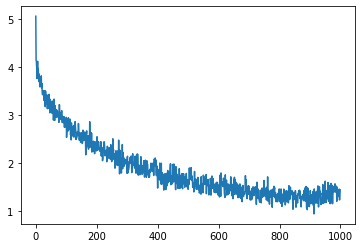

In [50]:
if __name__ == '__main__':
    trainIters(encoder1, attn_decoder1, n_iters, print_every=print_every)

je vous en de besoin de voir . <EOS>


<Figure size 432x288 with 0 Axes>

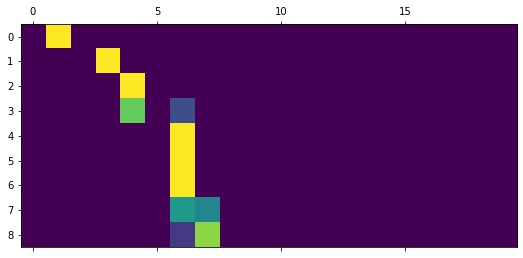

In [55]:
sentence = "i love you"
output_words, attention = evaluate(encoder1, attn_decoder1, sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)
plt.figure()
plt.matshow(attention.numpy())
plt.savefig("./s2s_attn.png")

In [53]:
evaluateRandomly(encoder1, attn_decoder1)

源语言: you re wasting time .
目的语言 vous gaspillez du temps .
翻译结果: vous gaspillez du temps . <EOS>
 
源语言: i m sorry i didn t recognize you .
目的语言 je suis desole je ne vous ai pas reconnues .
翻译结果: je suis desole je ne vous ai pas reconnue . <EOS>
 
源语言: she is proficient in both spanish and italian .
目的语言 elle est tres competente en espagnol et en italien .
翻译结果: elle est tres fachee en espagnol et en italien . <EOS>
 
源语言: you re too old for me .
目的语言 vous etes trop vieille pour moi .
翻译结果: vous etes trop vieille pour moi . <EOS>
 
源语言: we re stuffed .
目的语言 nous sommes gaves .
翻译结果: nous sommes jeunes . <EOS>
 
源语言: he is about my age .
目的语言 il a environ mon age .
翻译结果: il a environ peu pres mon age . <EOS>
 


In [57]:
    model_path = "seq2seq_translation_model.pth"
    torch.save({
        'encoder_state_dict': encoder1.state_dict(),
        'decoder_state_dict': attn_decoder1.state_dict(),
        'input_lang': {
            'name': input_lang.name,
            'word2index': input_lang.word2index,
            'index2word': input_lang.index2word,
            'n_words': input_lang.n_words
        },
        'output_lang': {
            'name': output_lang.name,
            'word2index': output_lang.word2index,
            'index2word': output_lang.index2word,
            'n_words': output_lang.n_words
        },
        'hidden_size': hidden_size,
        'max_length': MAX_LENGTH
    }, model_path)
    print(f"模型已保存至 {model_path}")

模型已保存至 seq2seq_translation_model.pth
